In [2]:
#IMPORT LIBRARIES
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use("default")


In [3]:
#IMPORT LIBRARIES
def get_rating(class_list):
    rating_map = {
        "One": 1,
        "Two": 2,
        "Three": 3,
        "Four": 4,
        "Five": 5
    }
    for key in rating_map:
        if key in class_list:
            return rating_map[key]
    return None


In [4]:
#SCRAPE BOOK LINKS 
base_url = "https://books.toscrape.com/catalogue/page-{}.html"
book_links = []

for page in range(1, 6):   # ONLY 5 pages
    print(f"Scraping page {page}")
    url = base_url.format(page)
    response = requests.get(url)
    
    soup = BeautifulSoup(response.text, "html.parser")
    books = soup.find_all("article", class_="product_pod")
    
    for book in books:
        link = book.find("a")["href"]
        full_link = "https://books.toscrape.com/catalogue/" + link
        book_links.append(full_link)

print("Total book links collected:", len(book_links))


Scraping page 1
Scraping page 2
Scraping page 3
Scraping page 4
Scraping page 5
Total book links collected: 100


In [17]:
#SCRAPE BOOK DETAILS (ADVANCED)
data = []

for link in book_links:
    response = requests.get(link)
    soup = BeautifulSoup(response.text, "html.parser")

    try:
        title = soup.find("h1").text
        
        price_text = soup.find("p", class_="price_color").text
        price = float(price_text.replace("£", "").encode("ascii", "ignore").decode())

        rating = get_rating(
            soup.find("p", class_="star-rating")["class"]
        )

        category = soup.find("ul", class_="breadcrumb").find_all("li")[2].text.strip()

        review_count = int(
            soup.find("table", class_="table table-striped")
            .find_all("tr")[6]
            .find("td").text
        )

        availability_text = soup.find("p", class_="instock availability").text
        availability = int("".join(filter(str.isdigit, availability_text)))

        data.append({
            "title": title,
            "price": price,
            "rating": rating,
            "review_count": review_count,
            "category": category,
            "availability": availability
        })

    except:
        continue

print("Total books scraped:", len(data))


Total books scraped: 100


In [6]:
print(len(data))


100


In [7]:
#CREATE DATAFRAME
df = pd.DataFrame(data)
df.head()


,title,price,rating,review_count,category,availability
0,A Light in the Attic,51.77,3,0,Poetry,22
1,Tipping the Velvet,53.74,1,0,Historical Fiction,20
2,Soumission,50.10,1,0,Fiction,20
3,Sharp Objects,47.82,4,0,Mystery,20
4,Sapiens: A Brief History of Humankind,54.23,5,0,History,20


In [8]:
#CREATE DATAFRAME
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

print("Rows after cleaning:", df.shape[0])


Rows after cleaning: 100


In [9]:
print(df.shape)
print(df.head())


(100, 6)
                                   title  price  rating  review_count  \
0                   A Light in the Attic  51.77       3             0   
1                     Tipping the Velvet  53.74       1             0   
2                             Soumission  50.10       1             0   
3                          Sharp Objects  47.82       4             0   
4  Sapiens: A Brief History of Humankind  54.23       5             0   

             category  availability  
0              Poetry            22  
1  Historical Fiction            20  
2             Fiction            20  
3             Mystery            20  
4             History            20  


In [10]:
#FEATURE ENGINEERING
# Price Band
def price_band(price):
    if price < 20:
        return "Low"
    elif price < 40:
        return "Medium"
    else:
        return "High"

df["price_band"] = df["price"].apply(price_band)

# Popularity Score
df["popularity_score"] = (df["rating"] * df["review_count"]) / (df["availability"] + 1)

# Value-for-Money Score
df["value_score"] = df["rating"] / df["price"]


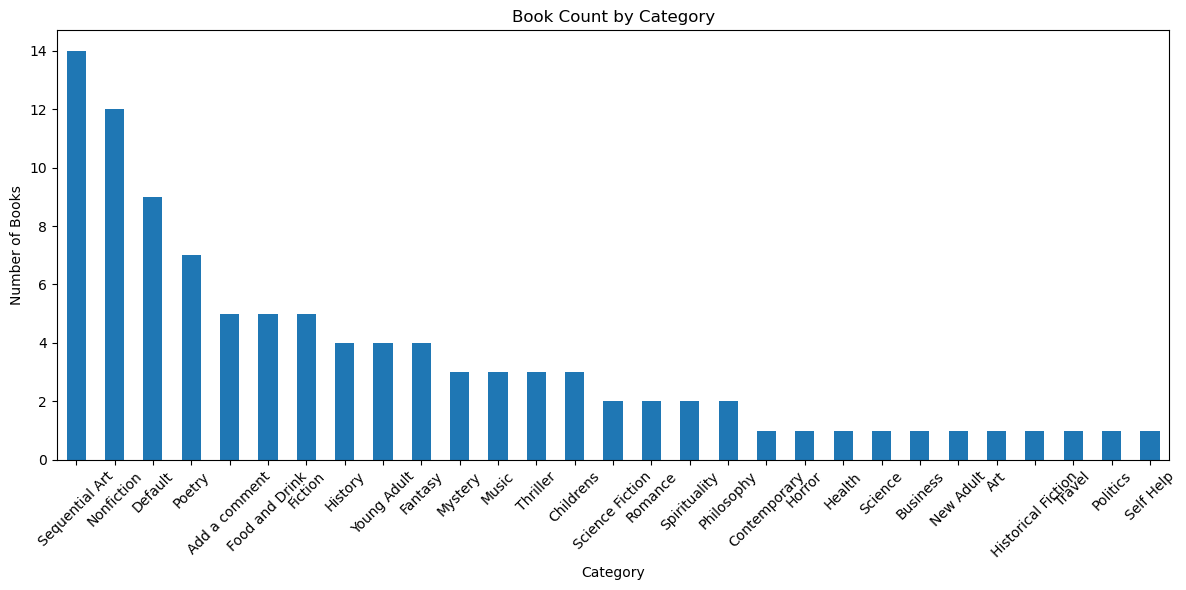

In [11]:
#CATEGORY ANALYSIS
category_counts = df["category"].value_counts()

plt.figure(figsize=(12,6))
category_counts.plot(kind="bar")
plt.title("Book Count by Category")
plt.xlabel("Category")
plt.ylabel("Number of Books")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


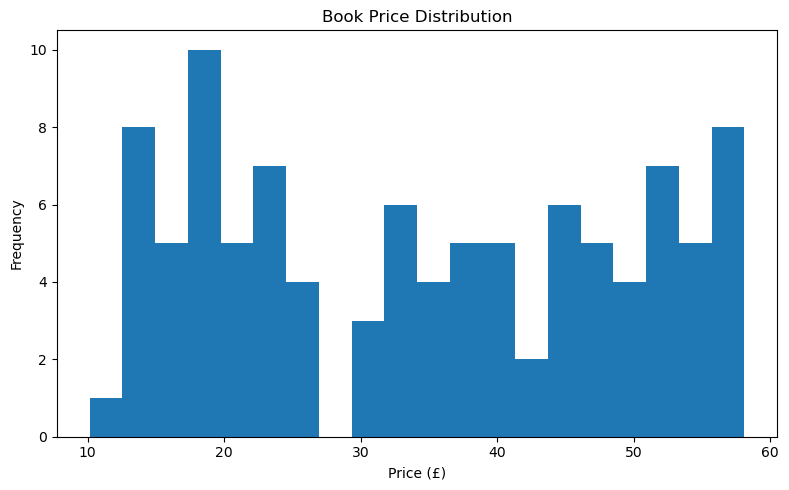

In [12]:
#CATEGORY ANALYSIS
plt.figure(figsize=(8,5))
df["price"].plot(kind="hist", bins=20)
plt.title("Book Price Distribution")
plt.xlabel("Price (£)")
plt.tight_layout()
plt.show()


In [13]:
#USER INPUT
print("📚 BOOK RECOMMENDATION SYSTEM")

category_input = input("Enter Category (or All): ").title()
min_rating = float(input("Enter Minimum Rating (1–5): "))
price_band_input = input("Enter Price Band (Low / Medium / High / All): ").title()
top_n = int(input("How many recommendations?: "))


📚 BOOK RECOMMENDATION SYSTEM


Enter Category (or All):  Fiction
Enter Minimum Rating (1–5):  1
Enter Price Band (Low / Medium / High / All):  Low
How many recommendations?:  4


In [18]:
#APPLY FILTERS
filtered = df.copy()

if category_input != "All":
    filtered = filtered[filtered["category"] == category_input]

filtered = filtered[filtered["rating"] >= min_rating]

if price_band_input != "All":
    filtered = filtered[filtered["price_band"] == price_band_input]

print("Books after filtering:", filtered.shape[0])


Books after filtering: 1


In [15]:
#TOP RECOMMENDATIONS
recommendations = (
    filtered
    .sort_values(by="value_score", ascending=False)
    .head(top_n)
)

recommendations[[
    "title",
    "category",
    "price",
    "rating",
    "review_count",
    "price_band",
    "value_score"
]]


,title,category,price,rating,review_count,price_band,value_score
54,Thirst,Fiction,17.27,5,0,Low,0.289519


In [19]:
# FULL SCRAPED DATA (NO FILTERS)
df.to_csv("books_full_cleaned_data.csv", index=False)

# ONLY USER-BASED RECOMMENDATIONS
recommendations.to_csv("top_book_recommendations.csv", index=False)

print("✅ CSV files saved successfully")


✅ CSV files saved successfully


In [16]:
#SAVE OUTPUT FILES
df.to_csv("books_full_cleaned_data.csv", index=False)
recommendations.to_csv("top_book_recommendations.csv", index=False)

print("✅ Project completed successfully")


✅ Project completed successfully
